In [3]:
# Make cells wider
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

In [4]:
import json
import numpy as np
import os

# !pip install pywebarchive
import webarchive


import re
import json
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

nparr = np.array

# Importing and loading data into Pandas DFs

In [5]:
# Load in eval trial data
def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext

gestureNames = ["Forward flick", "Right flick", "Right tilt", "Left flick", \
                "Left tilt", "Pull close", "Push away", "Turn to right", "Turn to left"]

# Import all webarchives in the directory
files = []
calib_files = []
for r,d,f in os.walk("."):
    for file in f:
        if 'GAZEL dot' in r:
            if ".webarchive" in file:
                files.append(os.path.join(r, file))
            elif "gazel_checkpoint" in file:
                calib_files.append(os.path.join(r, file))


# Webarchive format -> parsed JSON dictionaries
fileData = []
for file in files:
    tmp = webarchive.open(file)
    jsonStr = cleanhtml(tmp._main_resource.data.decode())
    try:
        jsonData = json.loads(jsonStr)
        for key in jsonData.keys():
            jsonData[key] = json.loads(jsonData[key])
        fileData.append(jsonData)
    except:
        print("Failed on " + file)
        
# Load in calibration round data

# 5 rounds, a = [[], [], [], [], []]
# Each round is made up of [x,y] pairs.
#   The x is embeddings
#   The y is dot ground truth
calibData = []
for calib_file in calib_files:
    with open(calib_file, 'r') as f:
        a = json.loads(f.read())
        for i in range(len(a)):
            a[i] = json.loads(a[i])
        calibData.append(a)
        
print("Successfully parsed " + str(len(fileData)) + " trials", end=" ")
print("and " + str(len(calibData)) + " calibration rounds")


Successfully parsed 10 trials and 10 calibration rounds


In [66]:
# Create DFs, making first a list of each trial separately, tagged with user ID and everything
dataList = []
calibList = []

for subNum in range(len(fileData)):
    print("Parsing subject #", subNum, end=", ")
    data = fileData[subNum]
    for evalName in data.keys():
        for gestureBlock in data[evalName]:
            for segment in gestureBlock:
                # Unpack each segment trial
                timestamp, detected, target, histories = segment

                detectedGest = detected[0]
                detectedGaze = detected[1]

                # Get the ground truth gesture and square out
                gestureTarget = target[0]
                gestureName = gestureNames[gestureTarget]
                gazeTarget = target[1]

                # Unpack the histories array
                headsize_hist, embeddings_hist, gazepreds_hist, IMU_hist, \
                                    gestdetect_hist, facevisible_hist = histories

                dataList.append([subNum, evalName, gestureName, gazeTarget, timestamp, 
                                 gestureTarget, gazeTarget, detectedGest, detectedGaze, 
                                 headsize_hist, embeddings_hist, gazepreds_hist, gestdetect_hist, IMU_hist, 
                                     facevisible_hist])

    subjectCalData = calibData[subNum]
    for calRound in subjectCalData:
        x,y = calRound
        for i in range(len(x)):
            calibList.append([subNum, [x[i]],y[i]])


# Target gestures are top to bottom
# | 1  5 |
# | 2  6 | 
# | 3  7 |
# | 4  8 |

Parsing subject # 0, Parsing subject # 1, Parsing subject # 2, Parsing subject # 3, Parsing subject # 4, Parsing subject # 5, Parsing subject # 6, Parsing subject # 7, Parsing subject # 8, Parsing subject # 9, 

In [67]:
# Adding columns to the eval DF and filtering             RUN CELL ABOVE FIRST
firstInd = 5
minLength = 10

# Function to filter the embeddings and gaze prediction histories based on movement
def getFirstActivity(lst):
    tmp = next((i for i,x in enumerate(lst) if sum(x) != 0), -1)
    # if tmp == -1: tmp = len(lst)
    return tmp

############## Create dataframe out of the list
GAZELdata = pd.DataFrame(dataList, columns=['Subject', "Set", "Gesture Target Name", "Gaze Target", "Timestamp",
       "Target Gesture", "Target Gaze", "Detected Gesture", "Detected Gaze",
        "Headsize Hist", "Embeddings Hist", "Gazepreds Hist", "Gestpreds Hist", "IMU Hist", "Face Detection Hist"
                                   ])
print("\nGAZELdata has length after creating DF: ", len(GAZELdata))


####### Find index of first motion, then trim each gazepred and embedding history there. 
            # Also remove the first few samples to get rid of reaction time
firstIndices = list(map(getFirstActivity, GAZELdata['Gestpreds Hist']))
for col in ['Gazepreds Hist', 'Embeddings Hist', 'Face Detection Hist']:
        GAZELdata[col] = list(map(lambda x: x[0][firstInd:(x[1]-1)], zip(GAZELdata[col],firstIndices)))

# #### Remove samples where head is not visible.
# indices = [np.argwhere(nparr(x) < .9) for x in GAZELdata['Face Detection Hist']]
# for col in ['Gazepreds Hist', 'Embeddings Hist', 'Face Detection Hist']:
#         GAZELdata[col] = list(map((lambda x: np.delete(x[0], x[1],axis=0)), zip(GAZELdata[col],indices)))        
        
# Then remove all rows where the length is too short (1 sample is about 100 ms)
GAZELdata = GAZELdata.loc[[len(x) >= minLength for x in GAZELdata['Gazepreds Hist']]]



######## Add grid? and Calib? column
GAZELdata["Grid?"] = [x[0] == "g" for x in GAZELdata["Set"]]
GAZELdata['Calib?'] = False


######### Add target locations in XY
GAZELdata['Gaze Target XY'] = np.zeros((len(GAZELdata), 2)).tolist()
def seg2GridCoords(segNum):
    return [(1 + (segNum-1)//4)/3, 1/8 + (((segNum-1) % 4) )/4]
def seg2ListCoords(segNum):
    return [0.5, 1/12 + (segNum-1)/6]

grids = [x[0]=='g' for x in GAZELdata['Set']]
lists = [not x for x in grids]

# GAZELdata.loc[grids, 'Gaze Target XY'] = pd.Series([seg2GridCoords(x) for x in GAZELdata.loc[grids, 'Gaze Target']])
# GAZELdata.loc[lists, 'Gaze Target XY'] = pd.Series([seg2ListCoords(x) for x in GAZELdata.loc[lists, 'Gaze Target']])
GAZELdata.loc[grids, 'Gaze Target XY'] = GAZELdata.loc[grids, 'Gaze Target'].map(seg2GridCoords)
GAZELdata.loc[lists, 'Gaze Target XY'] = GAZELdata.loc[lists, 'Gaze Target'].map(seg2ListCoords)


######## Add raw XY from base model
GAZELdata['Raw Gazepreds Hist'] = [[y[12:14] for y in x] for x in GAZELdata['Embeddings Hist']]


print("After filtering, GAZELdata has length: ", len(GAZELdata))
# # Plot one of the eye histories for fun
# plt.plot(GAZELdata['Gazepreds Hist'][0])


GAZELdata has length after creating DF:  3780
After filtering, GAZELdata has length:  3615


In [68]:
# Create calib DF and training DF
def xyToSegGrid(lst):
    x,y = lst
    return int(((y//.25)+1) + 4*(x > .5))

def xyToSegList(lst):
    x,y = lst
    return int(y//(1/6) + 1)

def f(clf, dataset):
    newOutputs = [np.mean(clf.predict(x), axis=0) for x in dataset['Embeddings Hist']]
    print("Testing abs error on same conditions as base model", mean_absolute_error(dataset['Gaze Target XY'].tolist(), newOutputs))
    
    # Accuracy for new model
    predSegs = []
    for i in range(len(newOutputs)):
        curXY = newOutputs[i]
#         print(dataset.iloc[i])
        if dataset.iloc[i]["Set"][0] == "g":
            predSeg = xyToSegGrid(curXY)
        else:
            predSeg = xyToSegList(curXY)
        predSegs.append(predSeg)

        
CALIBdata = pd.DataFrame(calibList, columns=["Subject", "Embeddings Hist", "Gaze Target XY"])
CALIBdata['Set'] = "grid" # Assume grid for accuracy calcs
CALIBdata['Gaze Target'] = CALIBdata['Gaze Target XY'].map(xyToSegGrid)
CALIBdata['Grid?'] = True
CALIBdata['Calib?'] = True


ALLdata = pd.concat([GAZELdata, CALIBdata], sort=False).reset_index()
print("All data length: ", len(ALLdata))

postDF = ALLdata[['Subject', 'Set', 'Calib?', 'Grid?', 'Embeddings Hist', 'Gaze Target XY', 'Gaze Target']].copy()

All data length:  17615


In [91]:
# Functions for getting base accuracy and cm error from a subject
def getBaseErrorCM(subjectData):
    a = np.array(subjectData['Gazepreds Hist'])
    b = [np.mean(x, axis=0) for x in a]
    return mean_absolute_error(subjectData['Gaze Target XY'].to_list(), b)

def getErrorWithModel(subjectData, model):
    a = subjectData['Gazepreds Hist']
    feats = subjectData['Embeddings Hist']
    b = [np.mean(model.predict(x), axis=0) for x in feats]

    return mean_absolute_error(subjectData['Gaze Target XY'].to_list(), b)

def printAcc(suff, correct, total):
    print(suff, str(correct) + "/" + str(total) + " = " + str(round(correct/total*100,2)) + "%")

def getNatureModelAccuracy(subData):
    xy = subData['Raw Gazepreds Hist']
    avgs = np.array([np.mean(x,axis=0) for x in xy])
    
    classOuts = np.zeros((len(avgs),1))
    classOuts[np.invert(grids)] = nparr(list(map(xyToSegList, avgs[np.invert(grids)]))).reshape(-1,1)
    classOuts[grids] = nparr(list(map(xyToSegGrid, avgs[grids]))).reshape(-1,1)
    
    printAcc("\nNature Model Base Accuracy:", sum(classOuts.reshape(1,-1)[0] == subData['Target Gaze']), len(subData))
    
def getBaseAccuracy(subData):
    gazeGT = subData['Target Gaze']
    gazePred = subData['Detected Gaze'].to_numpy().astype(int)
    correct = sum(gazeGT == gazePred)
    printAcc("\nUnprocessed Gaze Accuracy:", correct, len(gazePred))
    
    gestGT = subData['Target Gesture']
    gestPred = subData['Detected Gesture']
    correct = sum(gestGT == gestPred)
    printAcc("Unprocessed Gestures Accuracy:", correct, len(gestPred))

# getBaseAccuracy(GAZELdata)
# getNatureModelAccuracy(GAZELdata)

getBaseErrorCM(GAZELdata)
# Add per-square metrics to this

0.17664659729583085

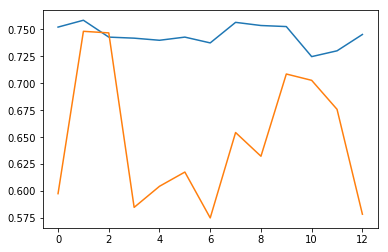

In [14]:
plt.plot(GAZELdata['Raw Gazepreds Hist'][80])

# The Machine Begins to Learn Regression

In [62]:
# List of regression models

import copy 
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR, NuSVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, \
    ExtraTreesRegressor,AdaBoostRegressor, VotingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.preprocessing import MinMaxScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import RepeatedKFold,cross_val_score
from sklearn.metrics import mean_absolute_error

models = [
    ExtraTreesRegressor(),
    ExtraTreesRegressor(n_estimators=100),
    ExtraTreesRegressor(n_estimators=100, max_depth=10),
    MLPRegressor(),
    MLPRegressor(solver="lbfgs"),
    MLPRegressor(hidden_layer_sizes=(32,128), max_iter=300, solver="lbfgs"),
    KNeighborsRegressor(n_neighbors = 16), 
    RandomForestRegressor(), 
    ExtraTreesRegressor(), 
    SVR(),
    NuSVR(),
    LinearSVR(),
    LinearRegression(),
#     RANSACRegressor() # Broken
]

#### Splitting data into pairs
def getRegressPairsFromTable(tbl, together=False): 
    c = []
    gridOrList = []
    gazeTargets = []
    for i in tbl.index:
        embeds = tbl.loc[i, 'Embeddings Hist']
        XY = tbl.loc[i, 'Gaze Target XY']
#         faceVis = tbl.loc[i, 'Face Detection Hist']
        if together:
            c.append([embeds[-6:],XY])
            gazeTargets.append(tbl.loc[i, 'Gaze Target'])
            gridOrList.append(tbl.loc[i, 'Set'])
        else:
            for j,sample in enumerate(embeds): 
                # remove samples where face is not visible
#                 if faceVis[j] > .9:
                c.append([sample, XY])
                gazeTargets.append(tbl.loc[i, 'Gaze Target'])
                gridOrList.append(tbl.loc[i, 'Set'])
    return c,gazeTargets, gridOrList


In [90]:
# Regression 
# GAZELdata, CALIBdata, ALLdata, postDF
def regressXYtogether_SingleEmbedThenVote(regressor, trainingDF, testingDF):
    train, trainGazetargs, trainSet = getRegressPairsFromTable(trainingDF, together=False)
    train_x = [np.array(x[0]).flatten() for x in train]
    train_y = [x[1] for x in train]

    print("Fitting...")
    model.fit(train_x, train_y)

    # Test on the testing data
    print("Predicting...")
    preds = [model.predict(x) for x in testingDF['Embeddings Hist']]
    avgedPreds = [x.mean(axis=0) for x in preds]
    p = testingDF['Gaze Target XY'].to_list()
    q = avgedPreds
    score = mean_absolute_error(p, q)
    
    print("Combined euclidean error:", score)
    print("model", regressor)
    return score


def regressXYseparate_SingleEmbedThenVote(regressor, trainingDF, testingDF):
    train, trainGazetargs, trainSet = getRegressPairsFromTable(trainingDF, together=False)
    train_x = [np.array(x[0]).flatten() for x in train]
    train_y_x = [x[1][0] for x in train]
    train_y_y = [x[1][1] for x in train]

    regressorX = regressor
    regressorY = copy.deepcopy(regressorX)
    print("Fitting...")
    regressorX.fit(train_x, train_y_x)
    regressorY.fit(train_x, train_y_y)
    
    # Test on the testing data
    print("Predicting...")
    preds_x = [regressorX.predict(x) for x in testingDF['Embeddings Hist']]
    preds_y = [regressorY.predict(x) for x in testingDF['Embeddings Hist']]
    avgedPreds_x = [x.mean() for x in preds_x]
    avgedPreds_y = [x.mean() for x in preds_y]
    p_x = [x[0] for x in testingDF['Gaze Target XY'].to_list()]
    p_y = [x[1] for x in testingDF['Gaze Target XY'].to_list()]
    q_x = avgedPreds_x
    q_y = avgedPreds_y
    score_x = mean_absolute_error(p_x, q_x)
    score_y = mean_absolute_error(p_y, q_y)

    print("Mean euclidean error x:", score_x, \
        "\n\t Centerimeter error (6.4cm width)", score_x*6.4)
    print("Mean euclidean error y:", score_y, \
        "\n\t Centerimeter error (12.8cm width)", score_y*12.8)
    
    print("Combined:", (score_x**2+score_y**2)**.5, \
          "\n\t Centimeters:", ((score_x*6.4)**2 + (score_y*12.8)**2)**.5)
    print("model", regressor)
    return score_x,score_y, (p_x, p_y, q_x, q_y)


regDF = GAZELdata.copy()
i=1
testDF = regDF.loc[regDF['Subject'] == i]
trainDF = regDF.drop(testDF.index).reset_index()

model = ExtraTreesRegressor(n_estimators=100)
# regressXYtogether_SingleEmbedThenVote(model, trainDF, testDF)
sx, sy, preds = regressXYseparate_SingleEmbedThenVote(model, trainDF, testDF)
# classifier_SingleEmbedThenVote(model, trainDF, testDF)






Fitting...
Predicting...
Mean euclidean error x: 0.07218408986165668 
	 Centerimeter error (6.4cm width) 0.4619781751146028
Mean euclidean error y: 0.20831049445246116 
	 Centerimeter error (12.8cm width) 2.666374328991503
Combined: 0.22046270643395582 
	 Centimeters: 2.7060997573236483
model ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
                    oob_score=False, random_state=None, verbose=0,
                    warm_start=False)


In [79]:
gtx,gty, predx, predy = preds

In [83]:
xerr = nparr(gtx) - nparr(predx)
yerr = nparr(gty) - nparr(predy)

In [89]:
print(np.std(xerr))
xerr.mean()

0.08490746625606498


0.020232891753687844

In [88]:
np.std(yerr)
yerr.mean()

-0.15804920019280225

# The Machine Begins to Learn Classification

In [557]:
# List of classifier models
from sklearn.neighbors import KNeighborsClassifier,RadiusNeighborsClassifier
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.svm import SVC, LinearSVC


from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report

from sklearn.metrics import mean_absolute_error,accuracy_score
import scipy
mode = scipy.stats.mode

import copy
dcopy = copy.deepcopy

# Classification
models = [
    KNeighborsClassifier(n_neighbors=14),
    ExtraTreesClassifier(),
    ExtraTreesClassifier(n_estimators=100),
    RandomForestClassifier(),
    RandomForestClassifier(n_estimators=100),
    SGDClassifier(),
    LogisticRegression(),
    SVC(),
    LinearSVC()
]

#### Splitting data into pairs
def getClassPairsFromTable(tbl, together=False): 
    c = []
    gridOrList = []
    gazeTargets = []
    for i in tbl.index:
        embeds = tbl.loc[i, 'Embeddings Hist']
        XY = tbl.loc[i, 'Gaze Target XY']
#         faceVis = tbl.loc[i, 'Face Detection Hist']
        if together:
            c.append([embeds[-6:],XY])
            gazeTargets.append(tbl.loc[i, 'Gaze Target'])
            gridOrList.append(tbl.loc[i, 'Set'])
        else:
            for j,sample in enumerate(embeds): 
                # remove samples where face is not visible
#                 if faceVis[j] > .9:
                c.append([sample, XY])
                gazeTargets.append(tbl.loc[i, 'Gaze Target'])
                gridOrList.append(tbl.loc[i, 'Set'])
    return c,gazeTargets, gridOrList


In [546]:
# Classification 
# GAZELdata, CALIBdata, ALLdata, postDF
def classifier_SingleEmbedThenVote(clf, trainingDF, testingDF):
    train, trainGazetargs, trainSet = getClassPairsFromTable(trainingDF, together=False)
    train_x = [np.array(x[0]).flatten() for x in train]
    train_y = trainGazetargs
#     print(train_y)

    print("Fitting...")
    clf.fit(train_x, train_y)
    
    # Test on the testing data
    print("Predicting...")
    voters = [clf.predict(x) for x in testingDF['Embeddings Hist']]
    voteOutputs = [mode(x).mode[0] for x in voters]
    preds = np.array(voteOutputs)
    gt = testingDF['Gaze Target'].to_numpy()
    print("score", sum(preds == gt)/len(preds))
    print("model", clf)
    return sum(preds == gt)/len(preds)



In [569]:
for i in range(9):
    print(i)
    classDF = GAZELdata.copy()
    classDF = classDF.loc[classDF['Grid?']]

    testDF = classDF.loc[classDF['Subject'] == i]
    trainDF = classDF.drop(testDF.index).reset_index()

    model = ExtraTreesClassifier(n_estimators=100)
    classifier_SingleEmbedThenVote(model, trainDF, testDF)



0
Fitting...
Predicting...
score 0.22596153846153846
model ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)
1
Fitting...
Predicting...
score 0.4413145539906103
model ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=Fal

In [568]:
# Did i fuck up by doing overlapping labels for the list and grid?
classDF = GAZELdata.copy()

# classDF.loc[grids, 'Gaze Target'] = classDF.loc[grids, 'Gaze Target'].map(seg2GridCoords)
# classDF.loc[lists, 'Gaze Target'] = classDF.loc[lists, 'Gaze Target'].map(lambda x: x+8)

# classDF = classDF.loc[np.invert(classDF['Grid?'])]
classDF = classDF.loc[classDF['Grid?']]

# split = 0.8
# trainDF = classDF.sample(frac = split)
# testDF = classDF.drop(trainDF.index).reset_index()

testDF = classDF.loc[classDF['Subject'] == 1]
trainDF = classDF.drop(testDF.index).reset_index()

# actualTrainDF = pd.concat([CALIBdata, trainDF], sort=False).reset_index()
# model = LinearSVC()
# model = KNeighborsClassifier(n_neighbors=14)
model = ExtraTreesClassifier(n_estimators=100)

classifier_SingleEmbedThenVote(model, trainDF, testDF)






Fitting...
Predicting...
score 0.4694835680751174
model ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)


0.4694835680751174

In [570]:
GAZELdata


,Subject,Set,Gesture Target Name,Gaze Target,Timestamp,Target Gesture,Target Gaze,Detected Gesture,Detected Gaze,Headsize Hist,Embeddings Hist,Gazepreds Hist,Gestpreds Hist,IMU Hist,Face Detection Hist,Grid?,Calib?,Gaze Target XY,Raw Gazepreds Hist
0,0,grid1_results,Forward flick,2,1616434383294,0,2,0,2.0,"[0.1906882832152095, 0.1895120090266511, 0.189...","[[-0.705078125, 0.8076171875, -1.1542967557907...","[[0.4613557685756841, 0.3631156789048672], [0....","[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0,...","[[[-0.3520515353194349, -2.9568364895792985, -...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",True,False,"[0.3333333333333333, 0.375]","[[0.46337890625, 0.6459961533546448], [0.35839..."
1,0,grid1_results,Forward flick,5,1616434388473,0,5,0,5.0,"[0.18809947422110418, 0.19202283786506694, 0.1...","[[-0.416015625, 0.1459961086511612, -1.0195311...","[[0.719554200690154, 0.23394008981498238], [0....","[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0,...","[[[6.905531279199869, 7.152999278113186, 6.072...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",True,False,"[0.6666666666666666, 0.125]","[[0.59521484375, 0.57958984375], [0.5395507812..."
2,0,grid1_results,Forward flick,8,1616434420179,0,8,0,7.0,"[0.20010598771663085, 0.20167264068744684, 0.2...","[[0.1462402492761612, 0.92822265625, -1.357421...","[[0.29995642679033613, 0.2197744162291284], [0...","[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0,...","[[[2.65778348695946, 2.752842004402878, 2.5485...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",True,False,"[0.6666666666666666, 0.875]","[[0.436767578125, 0.3247070610523224], [0.5883..."
3,0,grid1_results,Forward flick,1,1616434427577,0,1,0,1.0,"[0.19748338608993662, 0.1972598458409196, 0.19...","[[-0.52294921875, 1.3076170682907104, -1.61621...","[[0.35897443772070214, 0.20501396331612182], [...","[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0,...","[[[0.7060812108163819, -0.06643207405398363, -...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",True,False,"[0.3333333333333333, 0.125]","[[0.319091796875, 0.57177734375], [0.318603515..."
4,0,grid1_results,Forward flick,4,1616434432434,0,4,0,4.0,"[0.19779903786780703, 0.19776046530903985, 0.1...","[[-0.935546875, 1.1728515625, -1.4609373807907...","[[0.43373716647642213, 0.49903127373134704], [...","[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0,...","[[[1.9935044746065844, 3.766655520644333, 4.36...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",True,False,"[0.3333333333333333, 0.875]","[[0.343505859375, 0.78759765625], [0.375488281..."
5,0,grid1_results,Forward flick,7,1616434437649,0,7,0,7.0,"[0.1899697835707616, 0.19144110308897724, 0.19...","[[-0.373779296875, 0.38818359375, -0.997070252...","[[0.6426327283910237, 0.35493296289066034], [0...","[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0,...","[[[-5.090141703004527, -5.209038220981524, -2....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",True,False,"[0.6666666666666666, 0.625]","[[0.61181640625, 0.74609375], [0.5595703125, 0..."
6,0,grid1_results,Forward flick,3,1616434442848,0,3,0,3.0,"[0.1944146794683886, 0.19411240570288132, 0.19...","[[-1.1982420682907104, 1.1347655057907104, -1....","[[0.46581639953955345, 0.48972175638087195], [...","[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0,...","[[[3.0059306086728808, 2.4327959884821824, 1.1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",True,False,"[0.3333333333333333, 0.625]","[[0.3342285454273224, 0.8076171875], [0.246337..."
7,0,grid1_results,Forward flick,6,1616434447921,0,6,0,7.0,"[0.19979161285692407, 0.20093605332820189, 0.2...","[[-1.1103514432907104, 0.1613769680261612, -0....","[[0.922514713165702, 0.5400822113838606], [0.8...","[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0,...","[[[-1.882793298019613, -0.5529441541173176, 0....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",True,False,"[0.6666666666666666, 0.375]","[[0.6826171875, 0.78271484375], [0.5810546875,..."
8,0,grid1_results,Push away,7,1616434454556,6,7,6,6.0,"[0.1980093417634124, 0.19858323329164143, 0.19...","[[-0.4421387016773224, 0.4428

In [545]:
len(testDF['Embeddings Hist'][0][0])

26

In [ ]:
########### Grid
ETC 
65.9 grid separate, with calib data added. ETC 100
65.4 grid separate, without calib data. ETC 100

KNN
70 grid sep, w/o calib. Using KNN 

SVC
63 

LinearSVC
47 


########### List
54 list without calib, KNN 12
49 list without calib, ETC 100
49.8 list with calib, labels from grid though. ETC 100           - REDO



In [508]:
np.invert(classDF['Grid?'])


0       False
1       False
2       False
3       False
4       False
5       False
6       False
7       False
8       False
9       False
10      False
12      False
13      False
14      False
15      False
16      False
17      False
18      False
19      False
20      False
21      False
22      False
23      False
24      False
25      False
26      False
27      False
28      False
29      False
30      False
        ...  
3209    False
3210    False
3211    False
3212    False
3213    False
3214    False
3215    False
3217    False
3218    False
3219    False
3220    False
3221    False
3222    False
3223    False
3224    False
3225    False
3226    False
3227    False
3228    False
3229    False
3230    False
3231    False
3232    False
3233    False
3234    False
3235    False
3236    False
3237    False
3238    False
3239    False
Name: Grid?, Length: 1895, dtype: bool

In [109]:
# subData = GAZELdata
# gazeGT = subData['Target Gaze'].to_numpy()
# gazePred = subData['Detected Gaze'].to_numpy().astype(int)


In [110]:
sum(gazeGT == gazePred)

1308